In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Group 6

# Is this Real? News Claim Verification Through Recognizing Textual Entailment

Dataset : We found a dataset matching our requirement from the Hugging Face datasets named [MultiNewsFactCeckingClaims](https://huggingface.co/datasets/tingchih/Multi_News_fact_checking_claims). Although the dataset contains 1M rows, we will be using data which suffices our computing power. The dataset contains Document(News Article), a Claim and a label(Entailed, Neutral, Contradiction).


Goal : The Project aims to develop a news claim check detector utilizing multiple news articles and claims associated with the news articles. Our dataset will primarily consist of multiple claims to a news article having different labels of Entailment, Contradiction and Neutral. The final model will be able to classify a given claim to the above set of labels by referring to the abundance articles.


Summary - We perform initial data cleaning and fit a baseline model inspired from Fake News Challenge [Riedel et al. (2017)](https://arxiv.org/pdf/1707.03264.pdf) which is a Style Based Approach. We however modified the MLP Architecture mentioned in the paper to our setting. The MLP classifier would use a single vector of term frequencies and TF-IDF cosine similarities which is fed as the Input to the MLP Architecture.


## **1.0 Data Cleaning**

In [2]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=bce554d4d5b3431fa60327615c2cc30f275a44d34791d7984845101983c4a4f0
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [21]:
import pandas as pd
import string
from nltk.corpus import stopwords
from langdetect import detect
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras import regularizers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#Removing  stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.graph_objects as go
import re

# Download the NLTK stop words data
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_csv('/content/drive/MyDrive/NLP Project/Data/article_claim_data.csv')
df.at[5, 'Documents']

'                                         Whoever digs a pit will fall into it; if someone rolls a stone, it will roll back on them.If you set a trap for others, you will get caught in it yourself. If you roll a boulder down on others, it will crush you instead.Whoever digs a pit will fall into it, and a stone will come back on him who starts it rolling.He who digs a pit will fall into it, and whoever rolls a stone, it will come back on him.He who digs a pit will fall into it, And he who rolls a stone, it will come back on him.Whoso diggeth a pit shall fall therein: and he that rolleth a stone, it will return upon him.The one who digs a pit will fall into it, and whoever rolls a stone--it will come back on him.If you dig a pit, you will fall in; if you start a stone rolling, it will roll back on you.People who set traps for others get caught themselves. People who start landslides get crushed.The one who digs a pit will fall into it, and whoever rolls a stone-- it will come back on him

In [5]:
print(df.at[5,'Claim'])
print(df.at[5,'label'])

Judge Rogers violated the separation of church and state by ordering Bundy to write out Proverbs 26:27 25 times a day.
0


In [6]:
#Removing special characters

df['Documents'] = df['Documents'].apply(lambda x: re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', x))
df['Documents'] = df['Documents'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [7]:
print(df.at[1, 'Documents'])

 Whoever digs a pit will fall into it if someone rolls a stone it will roll back on them.If you set a trap for others you will get caught in it yourself. If you roll a boulder down on others it will crush you instead.Whoever digs a pit will fall into it and a stone will come back on him who starts it rolling.He who digs a pit will fall into it and whoever rolls a stone it will come back on him.He who digs a pit will fall into it And he who rolls a stone it will come back on him.Whoso diggeth a pit shall fall therein and he that rolleth a stone it will return upon him.The one who digs a pit will fall into it and whoever rolls a stone it will come back on him.If you dig a pit you will fall in if you start a stone rolling it will roll back on you.People who set traps for others get caught themselves. People who start landslides get crushed.The one who digs a pit will fall into it and whoever rolls a stone it will come back on him.Whoever digs a pit will fall into it and the stone will com

In [8]:
# Remove stop words from 'Documents'
stop_words = set(stopwords.words('english'))
df['Documents'] = df['Documents'].apply(lambda x: ' '.join([word for word in word_tokenize(str(x)) if word.lower() not in stop_words]))

In [9]:
# Display the cleaned DataFrame
print(df.at[0, 'Documents'])

Whoever digs pit fall someone rolls stone roll back them.If set trap others get caught . roll boulder others crush instead.Whoever digs pit fall stone come back starts rolling.He digs pit fall whoever rolls stone come back him.He digs pit fall rolls stone come back him.Whoso diggeth pit shall fall therein rolleth stone return upon him.The one digs pit fall whoever rolls stone come back him.If dig pit fall start stone rolling roll back you.People set traps others get caught . People start landslides get crushed.The one digs pit fall whoever rolls stone come back him.Whoever digs pit fall stone come back whoever starts rolling.The one digs pit fall one rolls stone come back him.Whoever digs pit shall fall . Whoever rolls stone come back him.He digs ditch fall rolls stone return upon him.Whoever digs pit fall . Whoever rolls stone roll back him.Whoso diggeth pit shall fall therein rolleth stone shall return upon him.He digs pit fall rolls stone come back him.Whosoever digs pit shall fall 

In [10]:
# Path to save the CSV file
output_csv_path = 'article_claim_cleaned.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

## **2.0 Baseline Model**

In [11]:
#Read the cleaned csv file
df1 = pd.read_csv('/content/drive/MyDrive/NLP Project/Data/article_claim_cleaned.csv')

In [12]:
# Create a training and test DataFrame
df_train = df1[:5994].copy() #Since they are independent, this ensures theres no imbalance between the classes
df_test = df1[5994:].copy()

In [13]:
df_train['Claim'][0]

'A complaint has been filed against the judge with the State Commission for Judicial Conduct.'

In [14]:
df_train['Documents'][0]

'Whoever digs pit fall someone rolls stone roll back them.If set trap others get caught . roll boulder others crush instead.Whoever digs pit fall stone come back starts rolling.He digs pit fall whoever rolls stone come back him.He digs pit fall rolls stone come back him.Whoso diggeth pit shall fall therein rolleth stone return upon him.The one digs pit fall whoever rolls stoneit come back him.If dig pit fall start stone rolling roll back you.People set traps others get caught . People start landslides get crushed.The one digs pit fall whoever rolls stone come back him.Whoever digs pit fall stone come back whoever starts rolling.The one digs pit fall one rolls stoneit come back him.Whoever digs pit shall fall . Whoever rolls stone come back him.He digs ditch fall rolls stone return upon him.Whoever digs pit fall . Whoever rolls stone roll back him.Whoso diggeth pit shall fall therein rolleth stone shall return upon him.He digs pit fall rolls stone come back him.Whosoever digs pit shall 

### 2.1 Feature Vectors for Training and Testing

In [15]:
# Dictionaries to keep track of unique heads and bodies for training
heads_track, bodies_track = {}, {}
test_heads_track, test_bodies_track = {}, {}

# Lists to store unique heads, bodies, and their corresponding indices for training
heads, bodies, body_ids = [], [], []
test_heads, test_bodies, test_body_ids = [], [], []

# Dictionary to map original indices to new indices for training
id_ref = {}

# Iterate through rows in the training dataframe
for index, row in df_train.iterrows():
    head, body = row['Claim'], row['Documents']

    # Track unique heads and bodies for training
    if head not in heads_track:
        heads.append(head)
        heads_track[head] = 1
    if body not in bodies_track:
        bodies.append(body)
        bodies_track[body] = 1
        body_ids.append(index)

# Create a mapping of original indices to new indices for training
for i, elem in enumerate(heads + body_ids):
    id_ref[elem] = i

# Use CountVectorizer-TF to create bag-of-words representation for training
bow_vectorizer = CountVectorizer(max_features=5000)
bow = bow_vectorizer.fit_transform(heads + bodies)

# Use TfidfTransformer to compute term frequencies for training
tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
tfreq = tfreq_vectorizer.transform(bow).toarray()

# Use TfidfVectorizer to compute TF-IDF representation for training
tfidf_vectorizer = TfidfVectorizer(max_features=5000).fit(heads + bodies)

# Lists to store features and labels for training
train_features, train_labels = [], []

# Dictionaries to keep track of TF-IDF vectors and cosine similarities for training
head_tfidf_track, body_tfidf_track, cos_track = {}, {}, {}

# Iterate through rows in the training dataframe
for index, row in df_train.iterrows():
    head, body = row['Claim'], row['Documents']
    body_id = body_ids[bodies.index(body)]

    # Extract TF representations for training
    head_tf = tfreq[id_ref[head]].reshape(1, -1)
    body_tf = tfreq[id_ref[body_id]].reshape(1, -1)

    # Check if TF-IDF vectors and cosine similarity are already computed for training
    if head not in head_tfidf_track:
        head_tfidf = tfidf_vectorizer.transform([head]).toarray()
        head_tfidf_track[head] = head_tfidf
    else:
        head_tfidf = head_tfidf_track[head]
    if body not in body_tfidf_track:
        body_tfidf = tfidf_vectorizer.transform([body]).toarray()
        body_tfidf_track[body] = body_tfidf
    else:
        body_tfidf = body_tfidf_track[body]
    if (head, body) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body)]

    # Concatenate features into a single vector for training
    feat_vec = np.squeeze(np.c_[head_tf, tfidf_cos, body_tf])

    # Append features and labels to the respective lists for training
    train_features.append(feat_vec)
    train_labels.append(row['label'])

In [16]:
# Dictionary to keep track of unique heads and bodies
heads_track, bodies_track = {}, {}
test_heads_track, test_bodies_track = {}, {}

# Lists to store unique heads, bodies, and their corresponding indices
heads, bodies, body_ids = [], [], []
test_heads, test_bodies, test_body_ids = [], [], []

# Dictionary to map original indices to new indices
id_ref = {}

# Iterate through rows in the test dataframe
for index, row in df_test.iterrows():
    head, body = row['Claim'], row['Documents']

    # Track unique heads and bodies
    if head not in heads_track:
        heads.append(head)
        heads_track[head] = 1
    if body not in bodies_track:
        bodies.append(body)
        bodies_track[body] = 1
        body_ids.append(index)

# Create a mapping of original indices to new indices
for i, elem in enumerate(heads + body_ids):
    id_ref[elem] = i

# Use CountVectorizer to create bag-of-words representation
bow_vectorizer = CountVectorizer(max_features=5000)
bow = bow_vectorizer.fit_transform(heads + bodies)

# Use TfidfTransformer to compute term frequencies
tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
tfreq = tfreq_vectorizer.transform(bow).toarray()

# Use TfidfVectorizer to compute TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000).fit(heads + bodies)

# Lists to store features and labels for the test set
test_features, test_labels = [], []

# Dictionaries to keep track of TF-IDF vectors and cosine similarities
head_tfidf_track, body_tfidf_track, cos_track = {}, {}, {}

# Iterate through rows in the test dataframe
for index, row in df_test.iterrows():
    head, body = row['Claim'], row['Documents']
    body_id = body_ids[bodies.index(body)]

    # Extract TF representations
    head_tf = tfreq[id_ref[head]].reshape(1, -1)
    body_tf = tfreq[id_ref[body_id]].reshape(1, -1)

    # Check if TF-IDF vectors and cosine similarity are already computed
    if head not in head_tfidf_track:
        head_tfidf = tfidf_vectorizer.transform([head]).toarray()
        head_tfidf_track[head] = head_tfidf
    else:
        head_tfidf = head_tfidf_track[head]
    if body not in body_tfidf_track:
        body_tfidf = tfidf_vectorizer.transform([body]).toarray()
        body_tfidf_track[body] = body_tfidf
    else:
        body_tfidf = body_tfidf_track[body]
    if (head, body) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body)]

    # Concatenate features into a single vector
    feat_vec = np.squeeze(np.c_[head_tf, tfidf_cos, body_tf])

    # Append features and labels to the respective lists
    test_features.append(feat_vec)
    test_labels.append(row['label'])

In [17]:
# Convert the training features and labels into NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

### 2.2 Baseline Model Building

In [18]:
model = Sequential()

#1st hidden layer
model.add(Dense(100, input_dim=train_features.shape[1], activation='relu'))
#Second hidden layer
model.add(Dense(50, activation='relu'))
#third hidden layer
model.add(Dense(25, activation='relu'))
#Output layer
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_labels, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


188/188 [==============================] - 4s 5ms/step - loss: 1.0838 - accuracy: 0.3655
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.9908 - accuracy: 0.4556
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.9053 - accuracy: 0.5033
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.8303 - accuracy: 0.5334
Epoch 5/20
188/188 [==============================] - 1s 3ms/step - loss: 0.7639 - accuracy: 0.5667
Epoch 6/20
188/188 [==============================] - 1s 3ms/step - loss: 0.7082 - accuracy: 0.5956
Epoch 7/20
188/188 [==============================] - 1s 3ms/step - loss: 0.6599 - accuracy: 0.6270
Epoch 8/20
188/188 [==============================] - 1s 3ms/step - loss: 0.6187 - accuracy: 0.6557
Epoch 9/20
188/188 [==============================] - 1s 3ms/step - loss: 0.5745 - accuracy: 0.7010
Epoch 10/20
188/188 [==============================] - 1s 3ms/step - loss: 0.5203 - accuracy: 0.7292
Epoch 11/2

In [25]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = range(1, len(df_history) + 1)
fig = go.Figure()

# Plot training accuracy
fig.add_trace(go.Scatter(x=df_history['epoch'], y=df_history['accuracy'],
                         mode='lines+markers', name='Training Accuracy'))

# Plot training loss on a secondary y-axis
fig.add_trace(go.Scatter(x=df_history['epoch'], y=df_history['loss'],
                         mode='lines+markers', name='Training Loss', yaxis='y2'))

# Update layout
fig.update_layout(title='Training Accuracy and Loss',
                  xaxis_title='Epochs',
                  yaxis_title='Accuracy',
                  yaxis2=dict(title='Loss', overlaying='y', side='right'),
                  template='plotly_white',
                  legend=dict(x=1.1, y=1, traceorder='normal'))

# Show the plot
fig.show()

## **3.0 Model Results**

In [ ]:
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
accuracy = accuracy_score(test_labels, predicted_labels)
macro_precision = precision_score(test_labels, predicted_labels, average='macro')
macro_recall = recall_score(test_labels, predicted_labels, average='macro')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

In [ ]:
metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'F1 Score']
values = [accuracy, macro_precision, micro_precision, f1]
fig = px.bar(x=metrics, y=values, text=np.round(values, 4),
             labels={'x': 'Metrics', 'y': 'Values'},
             title='Evaluation Metrics',
             template='plotly_white',
              color=values,
             color_continuous_scale='Viridis',
              color_continuous_midpoint=None
             )

fig.update_layout(yaxis=dict(range=[0, 1]))

fig.show()

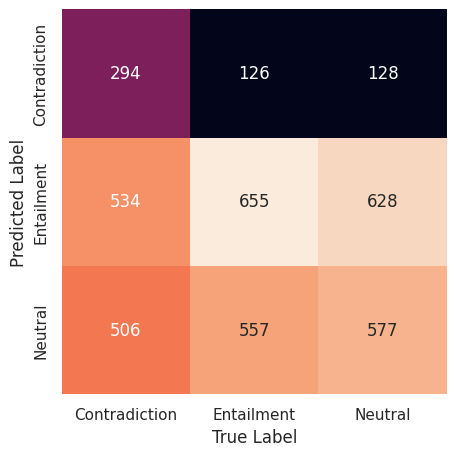

In [ ]:
class_labels = ['Contradiction','Entailment','Neutral']
mat = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')